In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import make_scorer
from sklearn.impute import SimpleImputer

# 1. Laden der Daten und Preprocessing

In [13]:

# Laden des Datensatzes
data_cleaned = "../data/cleaned_train.csv"
data = pd.read_csv(data_cleaned, delimiter=",", encoding="latin", header=0, thousands=",", decimal='.', low_memory=False)


# Definiere die numerischen und kategorischen Features
numerical_features = ['year', 'month', 'day', 'week_of_year', 'fourier_sin_365', 'fourier_cos_365',	'days_since_last_holiday',	'days_until_next_holiday'] # lag_1, lag_7 entfernt

# Bereits encodierte Features
already_encoded_features = ['Promo', 'promo2']

# Noch nicht encodierte kategorische Features
categorical_features_to_encode = ['DayOfWeek', 'StoreType', 'StateHoliday','Assortment', 'Store']

# Datensatz sortieren, falls nicht bereits geschehen (angenommen, du hast eine Spalte 'Date')
data = data.sort_values('Date')
data = data[data ['Open']!=0]
data = data[data ['Sales']>0]

# Zielvariable und Features definieren
X = data.drop(['Sales', 'Date', 'Open'], axis=1)  # 'Date' wird entfernt, wenn es keine erklärende Variable ist
y = data['Sales']

# Berechnung der Anzahl der Testdaten (20 % des Datensatzes)
test_size = int(len(data) * 0.2)

# Aufteilen der Daten in Trainings- und Testdaten
X_train, X_test = X.iloc[:-test_size], X.iloc[-test_size:]
y_train, y_test = y.iloc[:-test_size], y.iloc[-test_size:]

print(X.columns)

Index(['Store', 'DayOfWeek', 'Promo', 'StateHoliday', 'year', 'month', 'day',
       'week_of_year', 'day_of_week', 'day_of_year', 'is_weekend',
       'is_holiday', 'is_school_holiday', 'StoreType', 'Assortment', 'promo2',
       'fourier_sin_365', 'fourier_cos_365', 'days_since_last_holiday',
       'days_until_next_holiday', 'lag_1', 'lag_7'],
      dtype='object')


In [ ]:
# Erstelle den Preprocessor für numerische und kategorische Features (ohne Datumsextraktion)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),  # Skalierung für numerische und bereits encodierte Features
        ('enc', 'passthrough', already_encoded_features),  # Bereits encodierte Features durchschleusen (keine weitere Transformation)
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features_to_encode)  # Nur noch nicht encodierte Features encodieren
    ])

# RMSPE Funktion definieren
def rmspe(y_true, y_pred):
    mask = y_true != 0
    y_true_filtered = y_true[mask]
    y_pred_filtered = y_pred[mask]
    return np.sqrt(np.mean(((y_true_filtered - y_pred_filtered) / y_true_filtered) ** 2))

# Scorer für Cross-Validation
rmspe_scorer = make_scorer(rmspe, greater_is_better=False)

# TimeSeriesSplit für Cross-Validation
tscv = TimeSeriesSplit(n_splits=5)

# 2. RandomForestRegression

n_estimators: 1 - Train RMSPE: 0.2853, Test RMSPE: 0.2084
n_estimators: 5 - Train RMSPE: 0.2466, Test RMSPE: 0.1716
n_estimators: 10 - Train RMSPE: 0.2420, Test RMSPE: 0.1656
n_estimators: 20 - Train RMSPE: 0.2376, Test RMSPE: 0.1638


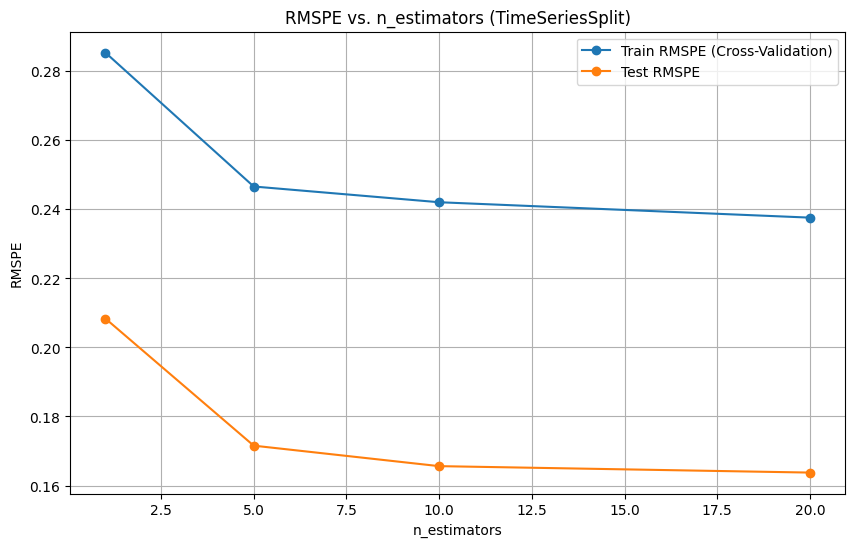

In [4]:
# Erstelle den Preprocessor für numerische und kategorische Features (ohne Datumsextraktion)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),  # Skalierung für numerische und bereits encodierte Features
        ('enc', 'passthrough', already_encoded_features),  # Bereits encodierte Features durchschleusen (keine weitere Transformation)
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features_to_encode)  # Nur noch nicht encodierte Features encodieren
    ])

# RMSPE Funktion definieren
def rmspe(y_true, y_pred):
    mask = y_true != 0
    y_true_filtered = y_true[mask]
    y_pred_filtered = y_pred[mask]
    return np.sqrt(np.mean(((y_true_filtered - y_pred_filtered) / y_true_filtered) ** 2))

# Scorer für Cross-Validation
rmspe_scorer = make_scorer(rmspe, greater_is_better=False)

# TimeSeriesSplit für Cross-Validation
tscv = TimeSeriesSplit(n_splits=5)

# Teste verschiedene Werte für n_estimators
n_estimators_range = [1, 5, 10, 20]
train_rmspe_scores = []
test_rmspe_scores = []

for n in n_estimators_range:
    # Erstelle die Pipeline mit dem aktuellen Wert für n_estimators
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', RandomForestRegressor(n_estimators=n, random_state=42))
    ])
    
    # Cross-Validation auf dem Trainingsdatensatz durchführen
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=tscv, scoring=rmspe_scorer)
    mean_cv_score = -np.mean(cv_scores)  # Da RMSPE negativ definiert ist
    
    # Trainiere das Modell auf dem gesamten Trainingsdatensatz
    pipeline.fit(X_train, y_train)
    
    # Vorhersagen auf dem Testdatensatz
    y_test_pred = pipeline.predict(X_test)
    
    # Berechne RMSPE für den Testdatensatz
    test_rmspe = rmspe(y_test, y_test_pred)
    
    # Speichere die Scores
    train_rmspe_scores.append(mean_cv_score)
    test_rmspe_scores.append(test_rmspe)
    
    # Ausgabe der Ergebnisse
    print(f"n_estimators: {n} - Train RMSPE: {mean_cv_score:.4f}, Test RMSPE: {test_rmspe:.4f}")

# Plotten der Ergebnisse
plt.figure(figsize=(10, 6))
plt.plot(n_estimators_range, train_rmspe_scores, label='Train RMSPE (Cross-Validation)', marker='o')
plt.plot(n_estimators_range, test_rmspe_scores, label='Test RMSPE', marker='o')
plt.xlabel('n_estimators')
plt.ylabel('RMSPE')
plt.title('RMSPE vs. n_estimators (TimeSeriesSplit)')
plt.legend()
plt.grid(True)
plt.show()

# 3. Abbildungen 

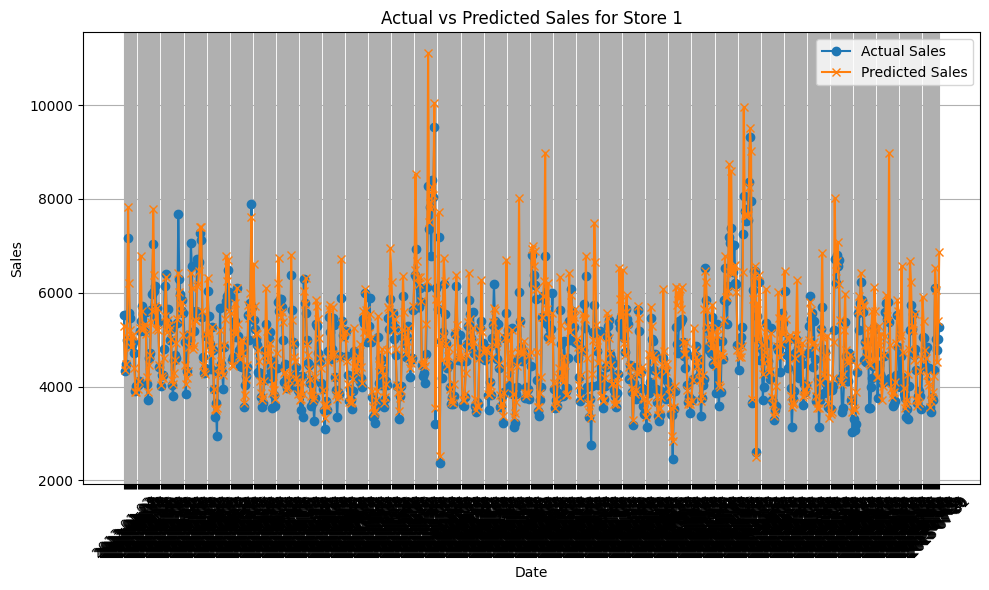

In [33]:
import matplotlib.pyplot as plt

# Wähle den Store aus, für den die Vorhersagen gemacht werden sollen
store_id = 1  # Beispiel: Store 1
store_data = data[data['Store'] == store_id]

# Teile die Daten für den Store in Features (X) und Zielvariable (y) auf
X_store = store_data.drop('Sales', axis=1)  # Merkmale ohne Sales
y_store = store_data['Sales']  # Tatsächliche Verkaufszahlen

# Berechne Vorhersagen für den Store
y_store_pred = pipeline.predict(X_store)

# Erstelle einen DataFrame, um die tatsächlichen und vorhergesagten Werte zu vergleichen
results = pd.DataFrame({
    'Date': store_data['Date'],
    'Actual Sales': y_store,
    'Predicted Sales': y_store_pred
})

# Sortiere die Ergebnisse nach Datum
results.sort_values('Date', inplace=True)

# Liniendiagramm für tatsächliche vs. vorhergesagte Verkaufszahlen
plt.figure(figsize=(10, 6))
plt.plot(results['Date'], results['Actual Sales'], label='Actual Sales', marker='o')
plt.plot(results['Date'], results['Predicted Sales'], label='Predicted Sales', marker='x')

plt.xlabel('Date')
plt.ylabel('Sales')
plt.title(f'Actual vs Predicted Sales for Store {store_id}')
plt.legend()
plt.grid(True)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


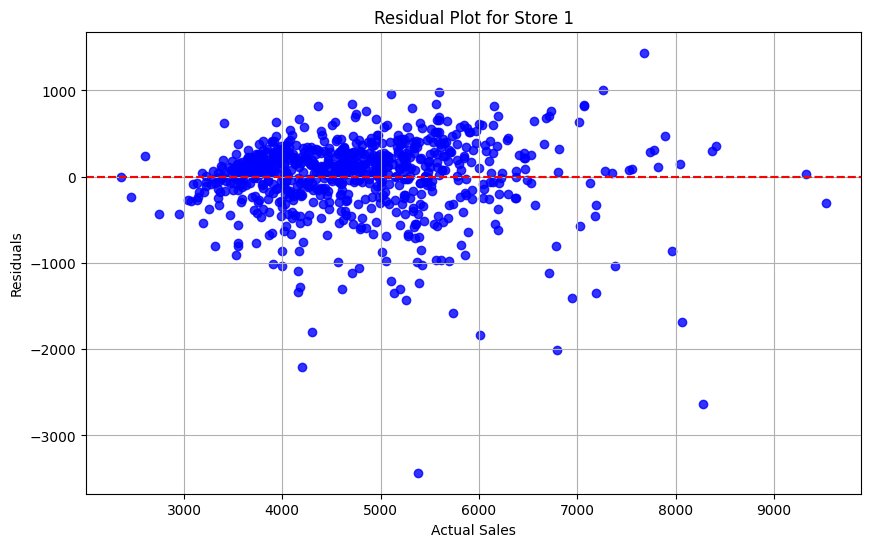

In [52]:
import seaborn as sns
# Residuals berechnen
results['Residuals'] = results['Actual Sales'] - results['Predicted Sales']

# Residual Plot ohne Lowess
plt.figure(figsize=(10, 6))
sns.residplot(x=results['Actual Sales'], y=results['Residuals'], color="blue")
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Actual Sales')
plt.ylabel('Residuals')
plt.title(f'Residual Plot for Store {store_id}')
plt.grid(True)
plt.show()



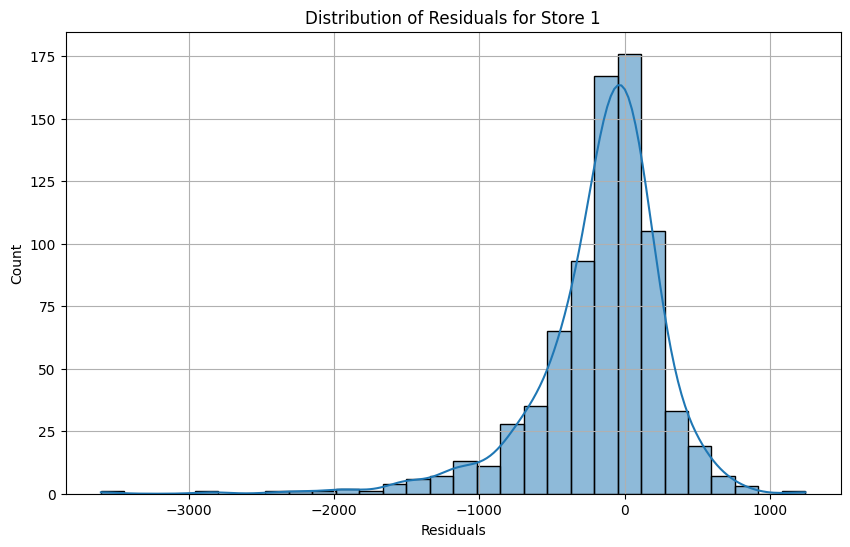

In [53]:
plt.figure(figsize=(10, 6))
sns.histplot(results['Residuals'], kde=True, bins=30)
plt.xlabel('Residuals')
plt.title(f'Distribution of Residuals for Store {store_id}')
plt.grid(True)
plt.show()


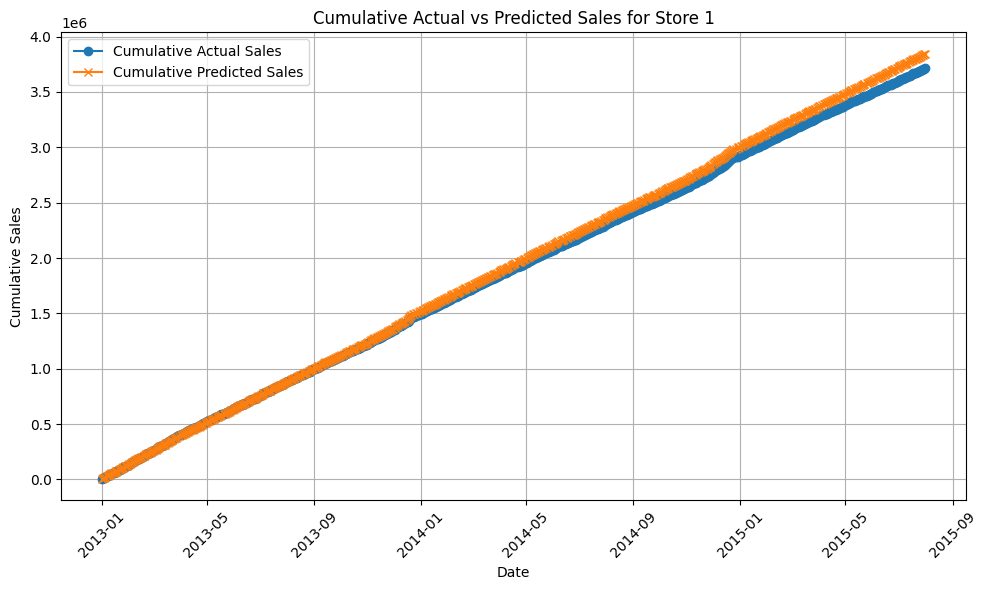

In [56]:
# Kumulierte Verkaufszahlen berechnen
results['Cumulative Actual Sales'] = results['Actual Sales'].cumsum()
results['Cumulative Predicted Sales'] = results['Predicted Sales'].cumsum()

# Plot kumulierter Verkaufszahlen
plt.figure(figsize=(10, 6))
plt.plot(results['Date'], results['Cumulative Actual Sales'], label='Cumulative Actual Sales', marker='o')
plt.plot(results['Date'], results['Cumulative Predicted Sales'], label='Cumulative Predicted Sales', marker='x')

plt.xlabel('Date')
plt.ylabel('Cumulative Sales')
plt.title(f'Cumulative Actual vs Predicted Sales for Store {store_id}')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


Was es zeigt: Zerlegt die Zeitreihe in ihre Bestandteile (Trend, Saisonalität und Residuen).
Warum es hilfreich ist: Dies kann dir helfen, saisonale Effekte oder Trends zu erkennen, die das Modell möglicherweise nicht richtig erfasst hat.

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Zeitreihenzerlegung der tatsächlichen Verkaufszahlen
decomposition = seasonal_decompose(results['Actual Sales'], period=30, model='additive')
decomposition.plot()
plt.suptitle(f'Time Series Decomposition for Store {store_id}')
plt.show()


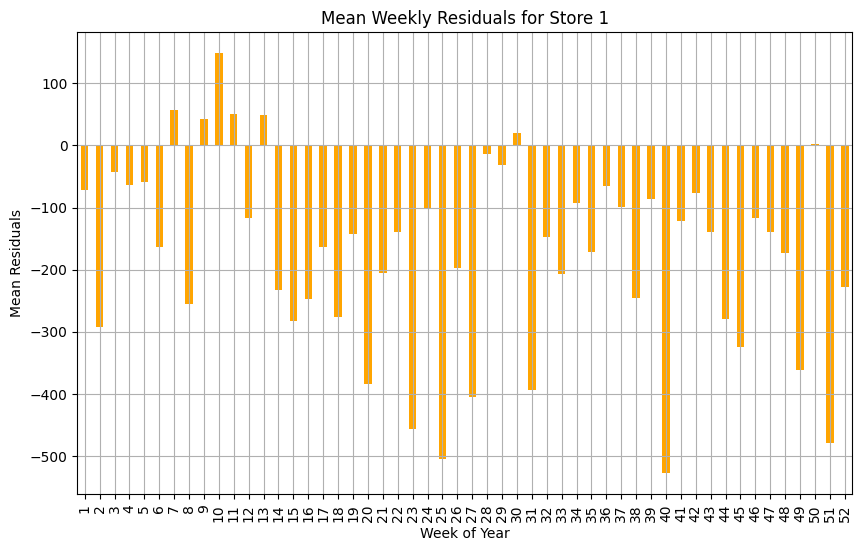

In [58]:
# Fehler pro Woche aggregieren
results['week_of_year'] = results['Date'].dt.isocalendar().week
weekly_errors = results.groupby('week_of_year')['Residuals'].mean()

# Balkendiagramm der mittleren wöchentlichen Fehler
plt.figure(figsize=(10, 6))
weekly_errors.plot(kind='bar', color='orange')
plt.xlabel('Week of Year')
plt.ylabel('Mean Residuals')
plt.title(f'Mean Weekly Residuals for Store {store_id}')
plt.grid(True)
plt.show()


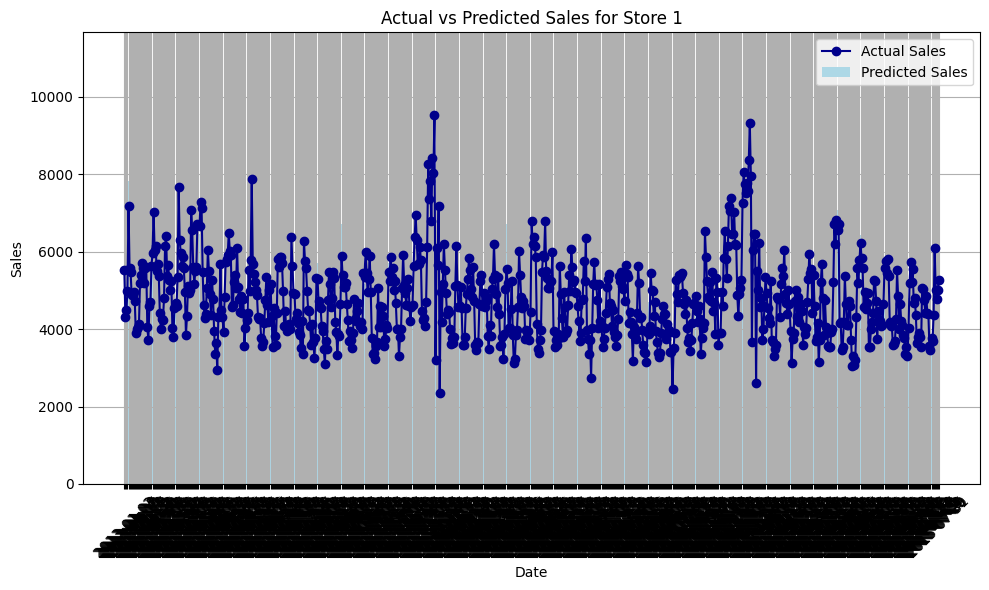

In [35]:
#balken + liniendiagramm
plt.figure(figsize=(10, 6))

# Balkendiagramm für die vorhergesagten Werte
plt.bar(results['Date'], results['Predicted Sales'], label='Predicted Sales', color='lightblue')

# Liniendiagramm für die tatsächlichen Verkaufszahlen
plt.plot(results['Date'], results['Actual Sales'], label='Actual Sales', color='darkblue', marker='o')

plt.xlabel('Date')
plt.ylabel('Sales')
plt.title(f'Actual vs Predicted Sales for Store {store_id}')
plt.legend()
plt.grid(True)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


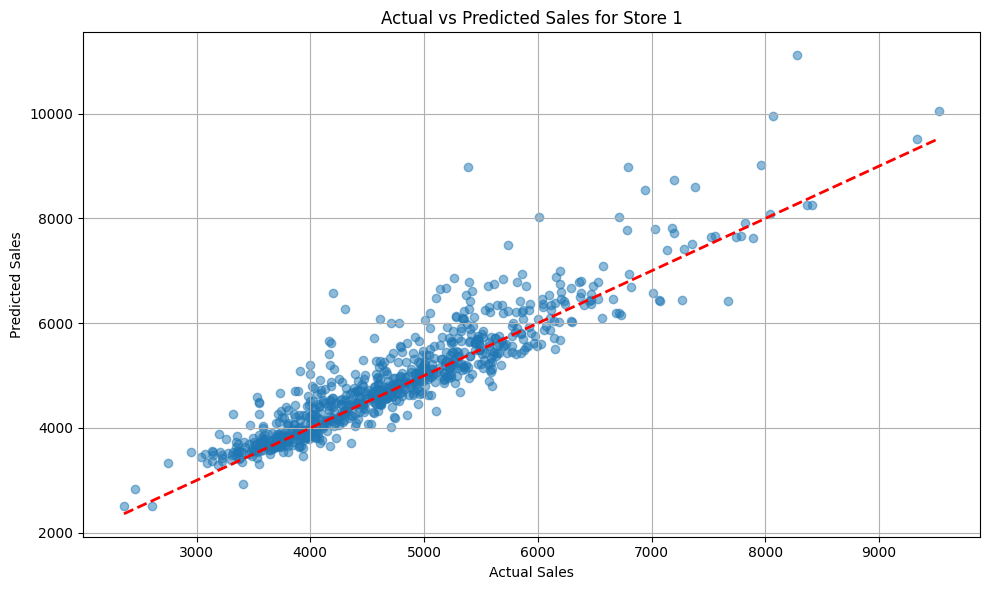

In [24]:
plt.figure(figsize=(10, 6))
plt.scatter(y_store, y_store_pred, alpha=0.5)
plt.plot([y_store.min(), y_store.max()], [y_store.min(), y_store.max()], 'r--', lw=2)
plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales')
plt.title(f'Actual vs Predicted Sales for Store {store_id}')
plt.grid(True)

plt.tight_layout()
plt.show()


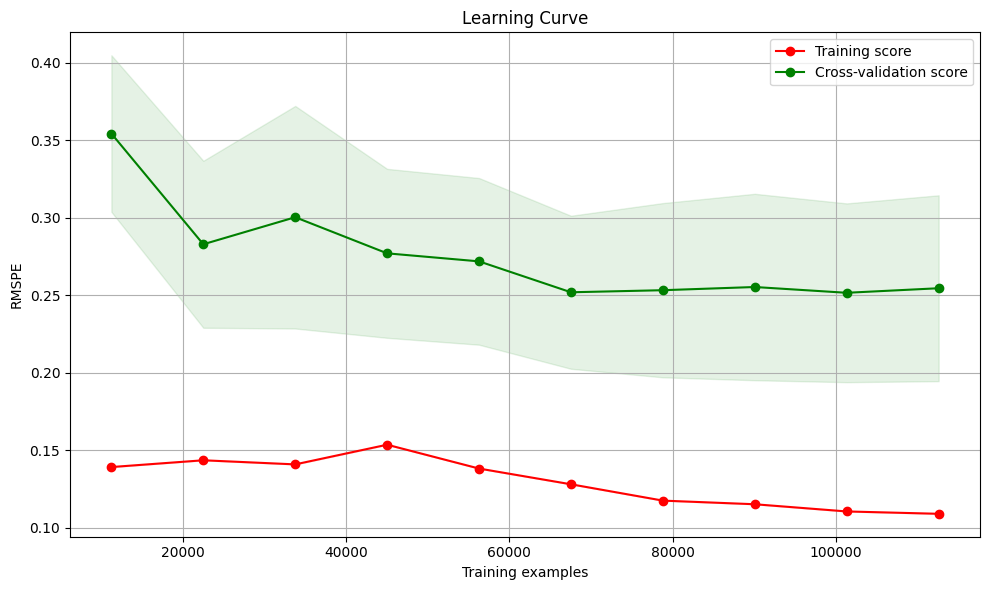

In [25]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(pipeline, X_train, y_train, cv=tscv, scoring=rmspe_scorer, train_sizes=np.linspace(0.1, 1.0, 10))

# Berechne die mittleren und Standardabweichungen der Scores
train_scores_mean = -np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot der Lernkurve
plt.figure(figsize=(10, 6))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

plt.xlabel("Training examples")
plt.ylabel("RMSPE")
plt.title("Learning Curve")
plt.legend(loc="best")
plt.grid(True)
plt.tight_layout()
plt.show()


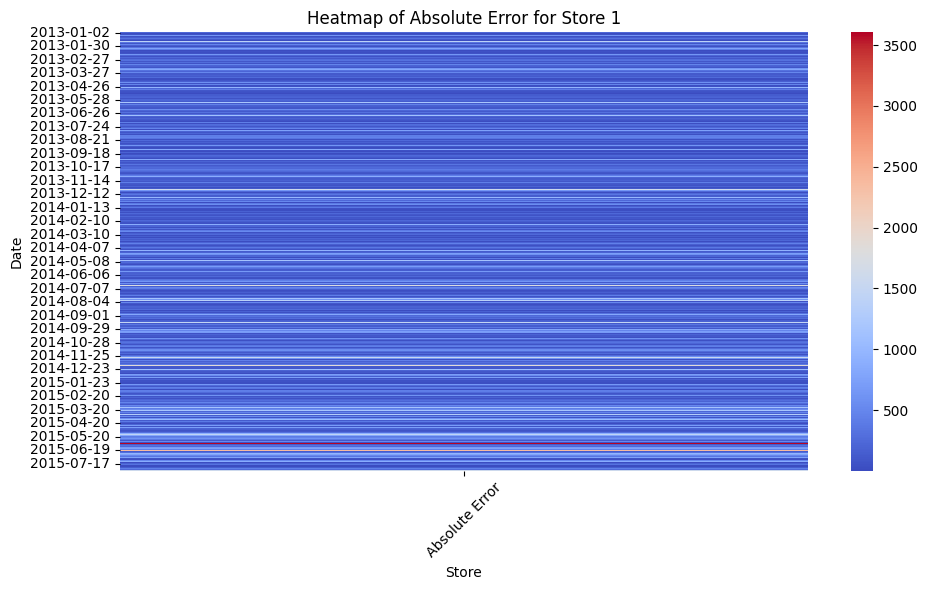

In [42]:
# Berechne absolute Abweichungen
results['Absolute Error'] = abs(results['Actual Sales'] - results['Predicted Sales'])

# Pivot-Tabelle erstellen
pivot_table = results.pivot_table(index='Date', values='Absolute Error', aggfunc='mean')

# Heatmap der Abweichungen
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, cmap="coolwarm", annot=False)

plt.title(f'Heatmap of Absolute Error for Store {store_id}')
plt.xlabel('Store')
plt.ylabel('Date')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [48]:
model = pipeline.named_steps['model']

importance_df = pd.DataFrame({
    'feature': numerical_features+already_encoded_features+categorical_features_to_encode,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)
print(importance_df.head(10))

# Plot to visualize most important feature
#sns.barplot(data=feature_importance_df, x='importance', y='feature')

ValueError: All arrays must be of the same length

# 4. Hyperparameteranpassung

In [18]:
from sklearn.model_selection import GridSearchCV

# Teste verschiedene Werte für n_estimators, max_depth, min_samples_split
param_grid = {
    'model__n_estimators': [1, 5, 10],
    'model__max_depth': [None, 10, 20],
    'model__min_samples_split': [2, 5, 10]
}

# Pipelineerstellung
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(random_state=42))
])

# GridSearchCV verwenden, um die besten Parameter zu finden
grid_search = GridSearchCV(pipeline, param_grid, cv=tscv, scoring=rmspe_scorer, n_jobs=-1)

# Fitting auf den Trainingsdatensatz
grid_search.fit(X_train, y_train)

# Vorhersagen auf dem Trainings- und Testdatensatz
y_train_pred = grid_search.predict(X_train)
y_test_pred = grid_search.predict(X_test)

# Berechne RMSPE für Trainings- und Testdatensatz
train_rmspe = rmspe(y_train, y_train_pred)
test_rmspe = rmspe(y_test, y_test_pred)

# Ausgabe der Ergebnisse
print(f"Beste Parameter: {grid_search.best_params_}")
print(f"Train RMSPE: {train_rmspe:.4f}")
print(f"Test RMSPE: {test_rmspe:.4f}")

Beste Parameter: {'model__max_depth': None, 'model__min_samples_split': 5, 'model__n_estimators': 10}
Train RMSPE: 0.1235
Test RMSPE: 0.1646


n_estimators: 1 - Train RMSPE: 0.2411, Test RMSPE: 0.1646


ValueError: x and y must have same first dimension, but have shapes (4,) and (1,)

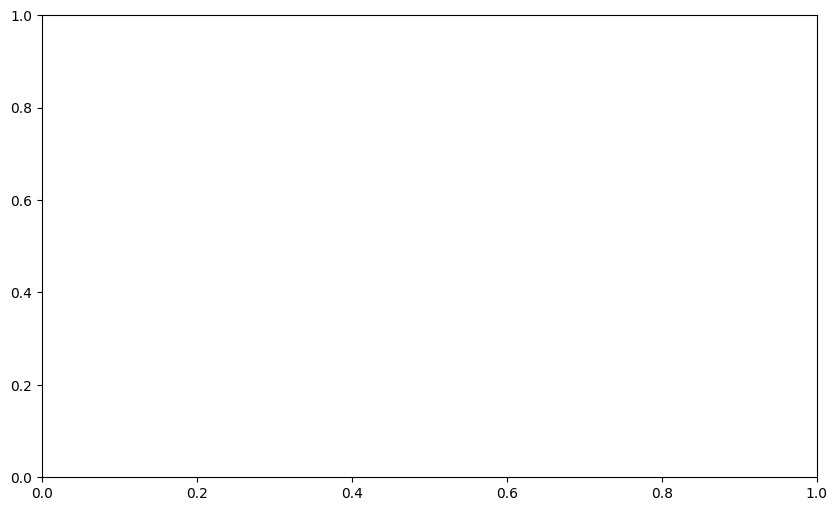

In [20]:
# Erstelle den Preprocessor für numerische und kategorische Features (ohne Datumsextraktion)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),  # Skalierung für numerische und bereits encodierte Features
        ('enc', 'passthrough', already_encoded_features),  # Bereits encodierte Features durchschleusen (keine weitere Transformation)
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features_to_encode)  # Nur noch nicht encodierte Features encodieren
    ])

# RMSPE Funktion definieren
def rmspe(y_true, y_pred):
    mask = y_true != 0
    y_true_filtered = y_true[mask]
    y_pred_filtered = y_pred[mask]
    return np.sqrt(np.mean(((y_true_filtered - y_pred_filtered) / y_true_filtered) ** 2))

# Scorer für Cross-Validation
rmspe_scorer = make_scorer(rmspe, greater_is_better=False)

# TimeSeriesSplit für Cross-Validation
tscv = TimeSeriesSplit(n_splits=5)

# Teste verschiedene Werte für n_estimators
n_estimators_range = [1, 5, 10, 20]
train_rmspe_scores = []
test_rmspe_scores = []


# Erstelle die Pipeline mit dem aktuellen Wert für n_estimators
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(n_estimators=10, min_samples_split=5, max_depth=None, random_state=42))
])

# Cross-Validation auf dem Trainingsdatensatz durchführen
cv_scores = cross_val_score(pipeline, X_train, y_train, cv=tscv, scoring=rmspe_scorer)
mean_cv_score = -np.mean(cv_scores)  # Da RMSPE negativ definiert ist

# Trainiere das Modell auf dem gesamten Trainingsdatensatz
pipeline.fit(X_train, y_train)

# Vorhersagen auf dem Testdatensatz
y_test_pred = pipeline.predict(X_test)

# Berechne RMSPE für den Testdatensatz
test_rmspe = rmspe(y_test, y_test_pred)

# Speichere die Scores
train_rmspe_scores.append(mean_cv_score)
test_rmspe_scores.append(test_rmspe)

# Ausgabe der Ergebnisse
print(f"n_estimators: {n} - Train RMSPE: {mean_cv_score:.4f}, Test RMSPE: {test_rmspe:.4f}")

# Plotten der Ergebnisse
plt.figure(figsize=(10, 6))
plt.plot(n_estimators_range, train_rmspe_scores, label='Train RMSPE (Cross-Validation)', marker='o')
plt.plot(n_estimators_range, test_rmspe_scores, label='Test RMSPE', marker='o')
plt.xlabel('n_estimators')
plt.ylabel('RMSPE')
plt.title('RMSPE vs. n_estimators (TimeSeriesSplit)')
plt.legend()
plt.grid(True)
plt.show()